<a href="https://colab.research.google.com/github/vlordier/colabs/blob/main/Multi_label_Emotion_Classification_%2B_W%26B(Model2)_Notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install datasets transformers -q

     |████████████████████████████████| 306 kB 6.9 MB/s 
     |████████████████████████████████| 3.4 MB 66.7 MB/s 
     |████████████████████████████████| 133 kB 68.8 MB/s 
     |████████████████████████████████| 1.1 MB 66.5 MB/s 
     |████████████████████████████████| 243 kB 71.6 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 62.5 MB/s 
     |████████████████████████████████| 3.3 MB 26.8 MB/s 
     |████████████████████████████████| 596 kB 66.3 MB/s 
     |████████████████████████████████| 271 kB 74.0 MB/s 
     |████████████████████████████████| 160 kB 74.9 MB/s 
     |████████████████████████████████| 144 kB 79.7 MB/s 


In [ ]:
!pip3 install wandb --upgrade -q

     |████████████████████████████████| 1.7 MB 7.8 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 142 kB 61.5 MB/s 
     |████████████████████████████████| 180 kB 72.1 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

from datasets import load_dataset
import random
from sklearn import metrics, model_selection, preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
def seed_everything(seed=73):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # some cudnn methods can be random even after fixing the seed unless you tell it to be deterministic
    torch.backends.cudnn.deterministic = True

seed_everything(1234)

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random', #grid, random, bayesian
    'metric': {
      'name': 'auc_score',
      'goal': 'maximize'   
    },
    'parameters': {

        'learning_rate': {
            'values': [3e-5]
        },
        'batch_size': {
            'values': [32]
        },
        'epochs':{'value': 10},
        'dropout':{
            'values': [0.5]
        },
        'tokenizer_max_len': {'value': 40},
    }
}

sweep_defaults = {
    'learning_rate': 3e-5,
    'batch_size': 64,
    'epochs': 10,
    'dropout': 0.3,
    'tokenizer_max_len': 40
}

sweep_id = wandb.sweep(sweep_config, project='bhaavnaye')

Create sweep with ID: 19f8zr3s
Sweep URL: https://wandb.ai/atif786/bhaavnaye/sweeps/19f8zr3s


In [ ]:
go_emotions = load_dataset("go_emotions")
data = go_emotions.data

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train, valid, test = data["train"].to_pandas(), data["validation"].to_pandas(), data["test"].to_pandas()

In [ ]:
print(train.shape, valid.shape, test.shape) 

(43410, 3) (5426, 3) (5427, 3)


In [ ]:
train.head()

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [ ]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [ ]:
def one_hot_encoder(df):
    one_hot_encoding = []
    for i in tqdm(range(len(df))):
        temp = [0]*n_labels
        label_indices = df.iloc[i]["labels"]
        for index in label_indices:
            temp[index] = 1
        one_hot_encoding.append(temp)
    return pd.DataFrame(one_hot_encoding)

In [ ]:
train_ohe_labels = one_hot_encoder(train)
valid_ohe_labels = one_hot_encoder(valid)
test_ohe_labels = one_hot_encoder(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [ ]:
train_ohe_labels.shape

(43410, 28)

In [ ]:
train = pd.concat([train, train_ohe_labels], axis=1)
valid = pd.concat([valid, valid_ohe_labels], axis=1)
test = pd.concat([test, test_ohe_labels], axis=1)

In [ ]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def inspect_category_wise_data(label, n=5):
    samples = train[train[label] == 1].sample(n)
    sentiment = mapping[label]
    
    print(f"{n} samples from {sentiment} sentiment: \n")
    for text in samples["text"]:
        print(text, end='\n\n')

In [ ]:
inspect_category_wise_data(4)

5 samples from approval sentiment: 

Yeah dude I like the brown sugar ones a lot, what’s the problem?

Yes. Combined.

Completely understandable. Maybe mom should book flights a little bit farther in advance next time though!

Doesn't mean any of those thing you liked are going to change. Not immediately anyways.

Ah ok! I figured I was getting it wrong.



In [ ]:
class GoEmotionDataset:
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels

        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        inputs = self.tokenizer.__call__(text,
                                        None,
                                        add_special_tokens=True,
                                        max_length=self.max_len,
                                        padding="max_length",
                                        truncation=True,
                                        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
class GoEmotionClassifier(nn.Module):
    def __init__(self, n_train_steps, n_classes, do_prob, bert_model):
        super(GoEmotionClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(do_prob)
        self.out = nn.Linear(768, n_classes)
        self.n_train_steps = n_train_steps
        self.step_scheduler_after = "batch"

    def forward(self, ids, mask):
        output_1 = self.bert(ids, attention_mask=mask)["pooler_output"]
        output_2 = self.dropout(output_1)
        output = self.out(output_2)
        return output

In [ ]:
tokenizer = transformers.SqueezeBertTokenizer.from_pretrained("squeezebert/squeezebert-uncased", do_lower_case=True)

def build_dataset(tokenizer_max_len):
    train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist(), tokenizer, tokenizer_max_len)
    valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist(), tokenizer, tokenizer_max_len)
    
    return train_dataset, valid_dataset

def build_dataloader(train_dataset, valid_dataset, batch_size):
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

    return train_data_loader, valid_data_loader

def ret_model(n_train_steps, do_prob):
  model = GoEmotionClassifier(n_train_steps, n_labels, do_prob, bert_model=bert_model)
  return model

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

In [ ]:
sample_train_dataset, _ = build_dataset(40)
print(sample_train_dataset[0])
len(sample_train_dataset)

{'ids': tensor([ 101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000,
        5660, 2870, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])}


43410

In [ ]:
bert_model = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")

Downloading:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def ret_optimizer(model):
    '''
    Taken from Abhishek Thakur's Tez library example: 
    https://github.com/abhishekkrthakur/tez/blob/main/examples/text_classification/binary.py
    '''
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    opt = AdamW(optimizer_parameters, lr=wandb.config.learning_rate)
    return opt

def ret_scheduler(optimizer, num_train_steps):
    sch = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)
    return sch

def loss_fn(outputs, labels):
    if labels is None:
        return None
    return nn.BCEWithLogitsLoss()(outputs, labels.float())

def log_metrics(preds, labels):
    preds = torch.stack(preds)
    preds = preds.cpu().detach().numpy()
    labels = torch.stack(labels)
    labels = labels.cpu().detach().numpy()
    
    '''
    auc_micro_list = []
    for i in range(n_labels):
      current_pred = preds.T[i]
      current_label = labels.T[i]
      fpr_micro, tpr_micro, _ = metrics.roc_curve(current_label.T, current_pred.T)
      auc_micro = metrics.auc(fpr_micro, tpr_micro)
      auc_micro_list.append(auc_micro)
    
    return {"auc": np.array(auc_micro).mean()}
    '''

    fpr_micro, tpr_micro, _ = metrics.roc_curve(labels.ravel(), preds.ravel())
    
    auc_micro = metrics.auc(fpr_micro, tpr_micro)
    return {"auc_micro": auc_micro}

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    '''
        Modified from Abhishek Thakur's BERT example: 
        https://github.com/abhishekkrthakur/bert-sentiment/blob/master/src/engine.py
    '''

    train_loss = 0.0
    model.train()
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        mask = d["mask"]
        targets = d["labels"]

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask)

        loss = loss_fn(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        scheduler.step()
    return train_loss
    

def eval_fn(data_loader, model, device):
    '''
        Modified from Abhishek Thakur's BERT example: 
        https://github.com/abhishekkrthakur/bert-sentiment/blob/master/src/engine.py
    '''
    eval_loss = 0.0
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            mask = d["mask"]
            targets = d["labels"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask)
            loss = loss_fn(outputs, targets)
            eval_loss += loss.item()
            fin_targets.extend(targets)
            fin_outputs.extend(torch.sigmoid(outputs))
    return eval_loss, fin_outputs, fin_targets

In [ ]:
def trainer(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataset, valid_dataset = build_dataset(config.tokenizer_max_len)
        train_data_loader, valid_data_loader = build_dataloader(train_dataset, valid_dataset, config.batch_size)
        print("Length of Train Dataloader: ", len(train_data_loader))
        print("Length of Valid Dataloader: ", len(valid_data_loader))

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        n_train_steps = int(len(train_dataset) / config.batch_size * 10)

        model = ret_model(n_train_steps, config.dropout)
        optimizer = ret_optimizer(model)
        scheduler = ret_scheduler(optimizer, n_train_steps)
        model.to(device)
        model = nn.DataParallel(model)
        wandb.watch(model)
        
        n_epochs = config.epochs

        best_val_loss = 100
        for epoch in tqdm(range(n_epochs)):
            train_loss = train_fn(train_data_loader, model, optimizer, device, scheduler)
            eval_loss, preds, labels = eval_fn(valid_data_loader, model, device)
          
            auc_score = log_metrics(preds, labels)["auc_micro"]
            print("AUC score: ", auc_score)
            avg_train_loss, avg_val_loss = train_loss / len(train_data_loader), eval_loss / len(valid_data_loader)
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "auc_score": auc_score,
            })
            print("Average Train loss: ", avg_train_loss)
            print("Average Valid loss: ", avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model, "./best_model.pt")  
                print("Model saved as current val_loss is: ", best_val_loss)    

In [ ]:
wandb.agent(sweep_id, function=trainer, count=6)

wandb: Agent Starting Run: 1lp9h1gl with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	tokenizer_max_len: 40


Length of Train Dataloader:  679
Length of Valid Dataloader:  85


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

AUC score:  0.5337823745657209


Run 1lp9h1gl errored: NameError("name 'train_loss' is not defined")
wandb: ERROR Run 1lp9h1gl errored: NameError("name 'train_loss' is not defined")
wandb: Agent Starting Run: cbp6nqf0 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 5e-05
wandb: 	tokenizer_max_len: 40


Length of Train Dataloader:  679
Length of Valid Dataloader:  85


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.
--- Logging error ---
Traceback (most recent call last):
  File "<ipython-input-28-09aabc061d73>", line 26, in trainer
    eval_loss, preds, labels = eval_fn(valid_data_loader, model, device)
  File "<ipython-input-25-004b50a8fe17>", line 39, in eval_fn
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 257, in __iter__
    for obj in super(tqdm_notebook, self).__iter__():
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1180, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1186, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1152, in _get_data
    succe

# **Model Evaluation using Confusion Matrix**

In [ ]:
import matplotlib.pyplot as plt1
 
y_true=[]
for i in range(0,len(val_labels)):
  if(val_labels[i][0]==1):
    y_true.append(0)
  if(val_labels[i][1]==1):
    y_true.append(1)
pred=model3.predict(val_data)
p=[]
for i in range(0,len(pred)):
  a=np.argmax(pred[i])
  p.append(a)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,p)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt1.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt1.imshow(cm, interpolation='nearest', cmap=cmap)
    plt1.title(title)
    plt1.colorbar()
    tick_marks = np.arange(len(classes))
    plt1.xticks(tick_marks, classes, rotation=45)
    plt1.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt1.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt1.ylabel('True label')
    plt1.xlabel('Predicted label')
    plt1.cm
    plt1.show()


In [ ]:
model=torch.load('./best_model.pt')
model.eval()

DataParallel(
  (module): GoEmotionClassifier(
    (bert): SqueezeBertModel(
      (embeddings): SqueezeBertEmbeddings(
        (word_embeddings): Embedding(30528, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): SqueezeBertEncoder(
        (layers): ModuleList(
          (0): SqueezeBertModule(
            (attention): SqueezeBertSelfAttention(
              (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (dropout): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=-1)
              (matmul_qk): MatMulWrapper()
              (matmul_qkv): MatMulWrapper()
      

In [ ]:
eval_loss, preds, labels = eval_fn(valid_data_loader, model, device)

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
actual=[]
p=[]
for i in range(len(preds)):
  p.append(torch.argmax(preds[i]).cpu().detach().numpy())
  actual.append(torch.argmax(labels[i]).cpu().detach().numpy())

Confusion matrix, without normalization


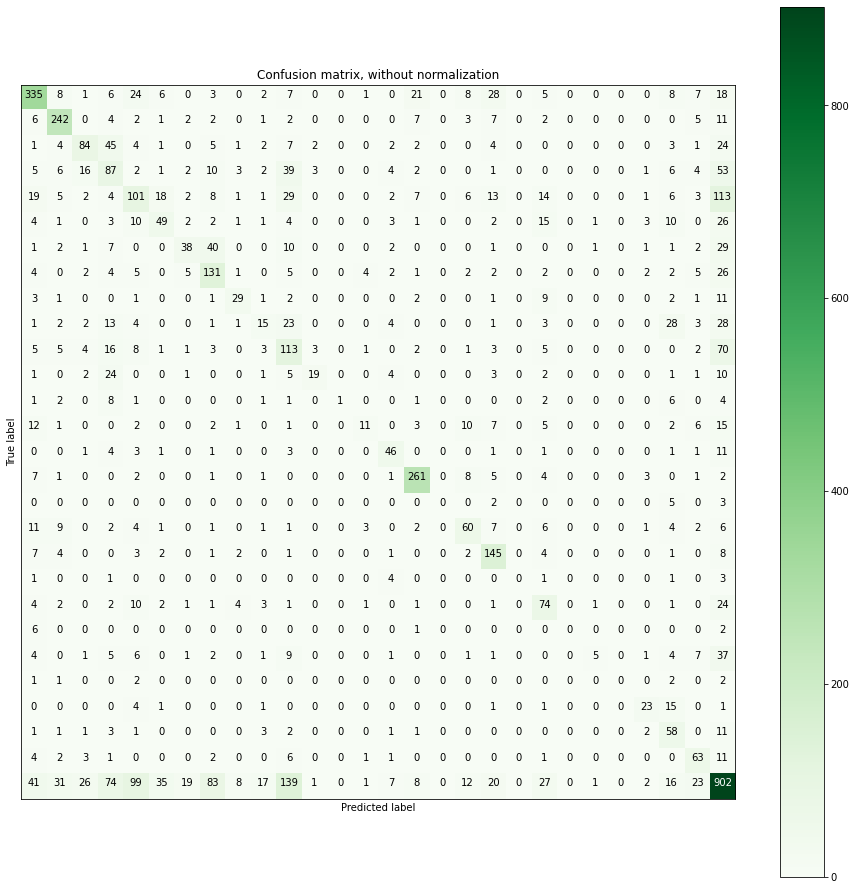

In [ ]:
import matplotlib.pyplot as plt1
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt1.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 

    plt1.imshow(cm, interpolation='nearest', cmap=cmap)
    plt1.title(title)
    plt1.colorbar()
    tick_marks = np.arange(len(classes))
    plt1.xticks(tick_marks, classes, rotation=45)
    plt1.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt1.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt1.ylabel('True label')
    plt1.xlabel('Predicted label')
    plt1.cm
    plt1.show()
cnf_matrix = confusion_matrix(actual, p)
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt1.figure(figsize=(16,16))
plot_confusion_matrix(cnf_matrix, classes=[],
                      
                      title='Confusion matrix, without normalization')